## Set up notebook

In [25]:
import os
import pickle as pkl
import copy 
import logging
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm 
import matplotlib.pyplot as plt
from naiad import load_naiad_data, NAIAD, ActiveLearner, ActiveLearnerReplicates
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

## Run NAIAD

In [2]:
# provide path to relevant data directories
data_file = '../data/drug/k562_ic50log_filter_data.csv'
result_dir = '../results/active_learning'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 2025
batch_size = 1024

In [3]:
# active learning pipeline arguments
n_round = 5
n_sample = [100, 200, 300, 400, 500] # number of samples to use in each learning round
test_frac = 0.3

model_args = {'embed_model': 'transformer-cls'}

n_ensemble = 5     # how many ensembles to use for each round?
n_epoch = 800       # how long to train each instance of the model

method = 'mean'    # active learning method
method_min = True  # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)

In [4]:
# provide path to relevant data directories
data_source = 'drug'

time_label = datetime.now().strftime(r'%Y-%m-%d-%H-%M-%S')
result_dir = os.path.join(result_dir, f'{data_source}_{time_label}')
os.makedirs(result_dir)

n_rep = 5          # how many replicates to run of active learning pipeline

In [5]:
# initialize active learner using same arguments as before
naiad_data = load_naiad_data(data_file)
active_learner = ActiveLearner(
    n_round = n_round, 
    data = naiad_data,
    n_ensemble = n_ensemble,
    n_epoch = n_epoch,
    n_sample = n_sample, 
    test_frac = test_frac, 
    model = NAIAD,
    model_args = model_args,
    early_stop = False,
    device = device,
    batch_size = batch_size,
    method = method,
    method_min = method_min
)

active_learner_reps = ActiveLearnerReplicates(
    n_rep=n_rep, 
    overall_seed=seed, 
    active_learner=active_learner, 
    save_dir=result_dir,
    save_prefix=data_source
)

In [6]:
active_learner_reps.set_method('mean', True)
results = active_learner_reps.run_replicates(parallel=True)             # parallel distributes the computation for faster processing
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.set_method('residual+std', False)
results = active_learner_reps.run_replicates(parallel=True)
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.set_method('std', False)
results = active_learner_reps.run_replicates(parallel=True)
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.save_aggregated_results(data_source)   # predictions for each round and replicate are stored in result_dir

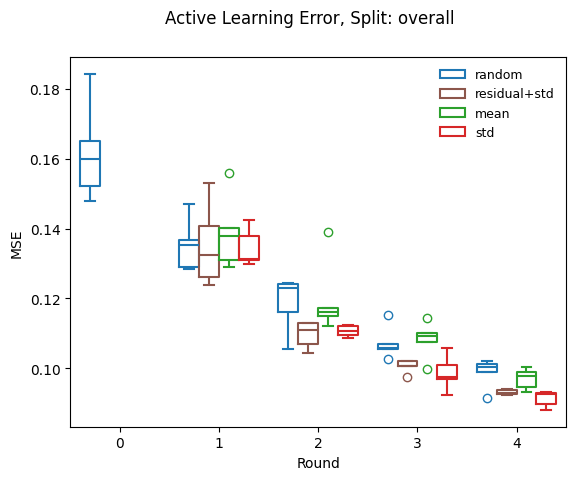

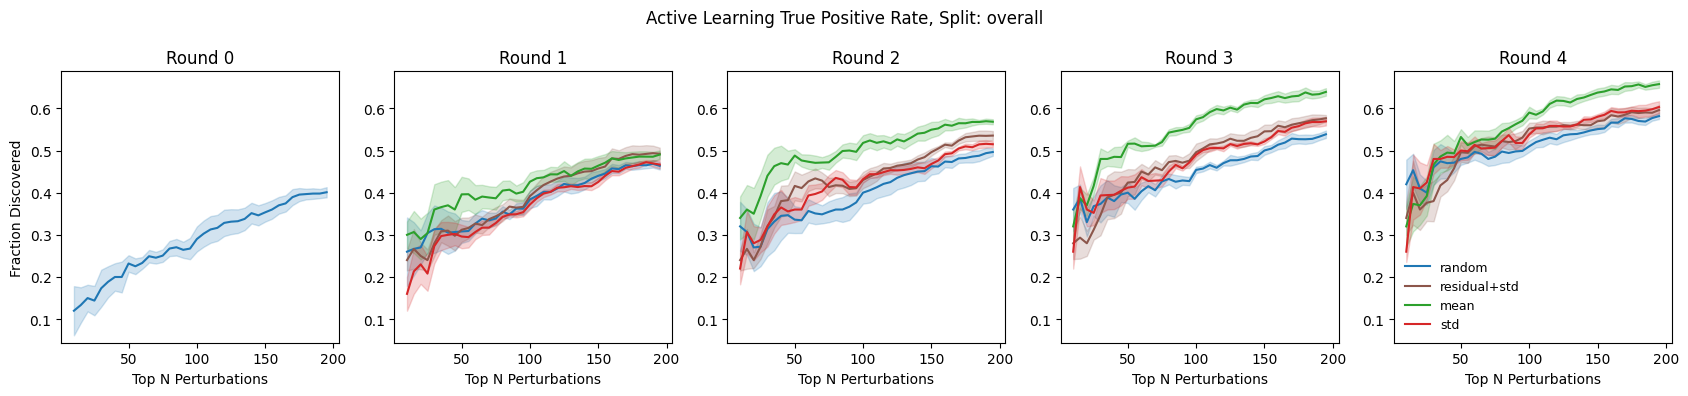

In [7]:
active_learner_reps.plot_aggregated_results(metrics = ['mse', 'tpr'], 
                                            splits = ['overall'],
                                            methods = ['residual+std', 'mean', 'std'],
                                            orientation = 'horizontal')

In [8]:
active_learner_reps_naiad = copy.deepcopy(active_learner_reps)

## Run RECOVER

In [9]:
model_args = {'model_type': 'recover'}

time_label = datetime.now().strftime(r'%Y-%m-%d-%H-%M-%S')
result_dir = os.path.join(result_dir, f'{data_source}_{time_label}')
os.makedirs(result_dir)

n_rep = 5          # how many replicates to run of active learning pipeline

method = 'mean'    # active learning method
method_min = True  # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)

In [10]:
active_learner = ActiveLearner(
    n_round = n_round, 
    data = naiad_data,
    n_ensemble = n_ensemble,
    n_epoch = n_epoch,
    n_sample = n_sample, 
    test_frac = test_frac, 
    model = NAIAD,
    model_args = model_args,
    early_stop = False,
    device = device,
    batch_size = batch_size,
    method = method,
    method_min = method_min
)

active_learner_reps = ActiveLearnerReplicates(
    n_rep=n_rep, 
    overall_seed=seed, 
    active_learner=active_learner, 
    save_dir=result_dir,
    save_prefix=data_source
)

In [11]:
active_learner_reps.set_method('mean', True)
results = active_learner_reps.run_replicates(parallel=True)             # parallel distributes the computation for faster processing
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.set_method('residual+std', False)
results = active_learner_reps.run_replicates(parallel=True)
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.set_method('std', False)
results = active_learner_reps.run_replicates(parallel=True)
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)

active_learner_reps.save_aggregated_results(data_source)   # predictions for each round and replicate are stored in result_dir

/Users/jasonqin/Documents/neptune/NAIAD/naiad/models.py:469: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  x0 = self.bilinear_weights.matmul(x[:, 0, :].T).T
/Users/jasonqin/Documents/neptune/NAIAD/naiad/models.py:469: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  x0 = self.bilinear_w

In [12]:
active_learner_reps_recover = copy.deepcopy(active_learner_reps)

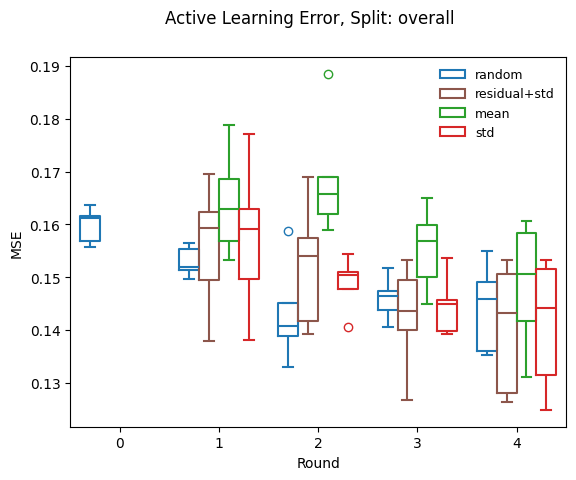

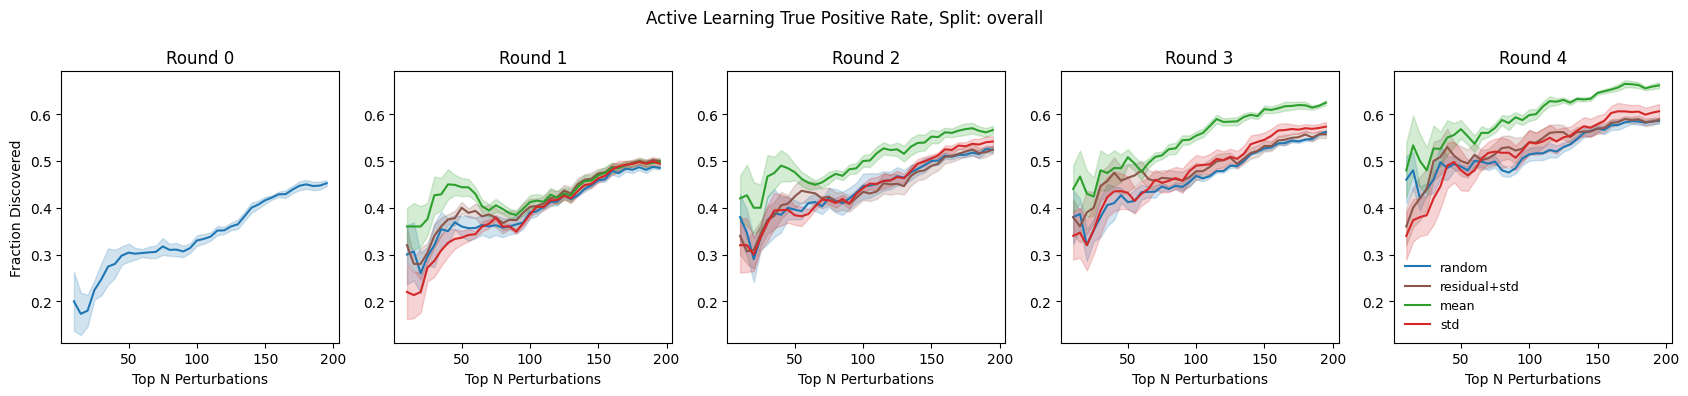

In [13]:
active_learner_reps.plot_aggregated_results(metrics = ['mse', 'tpr'], 
                                            splits = ['overall'],
                                            methods = ['residual+std', 'mean', 'std'],
                                            orientation = 'horizontal')
                        

## Plotting

In [14]:
metric = 'tpr'
split = 'overall'
methods = ['mean_naiad', 'residual+std_recover']
n_round = 5
max_tpr = 200

method_colors = { # colors for plotting measuerments of different `methods`
    'random_naiad': '#1f77b4',  # blue
    'mean_naiad': '#2ca02c',     # green
    'random_recover': '#d62728',         # red
    'mean_recover': '#ff7f0e',     # orange
    'residual+std_naiad': '#9467bd',       # purple
    'residual+std_recover': '#8c564b'          # brown
}

min_ylim = np.inf
max_ylim = -np.inf


In [15]:
seeds = active_learner_reps_recover.seeds

In [16]:
data_recover = copy.deepcopy(active_learner_reps_recover.aggregated_metrics_across_seeds[metric][split])
data_recover = data_recover.loc[data_recover['Round'] < n_round, :]

data_naiad = copy.deepcopy(active_learner_reps_naiad.aggregated_metrics_across_seeds[metric][split])
data_naiad = data_naiad.loc[data_naiad['Round'] < n_round, :]

data_recover = pd.melt(data_recover, id_vars=['Round', 'n_preds', 'Method', 'Sampling'], value_vars=seeds, var_name='seed', value_name='tpr')
data_recover.loc[:, 'Method'] = data_recover.loc[:, 'Method'] + '_recover'

data_naiad = pd.melt(data_naiad, id_vars=['Round', 'n_preds', 'Method', 'Sampling'], value_vars=seeds, var_name='seed', value_name='tpr')
data_naiad.loc[:, 'Method'] = data_naiad.loc[:, 'Method'] + '_naiad'

data_stacked = pd.concat([data_recover, data_naiad], axis=0)

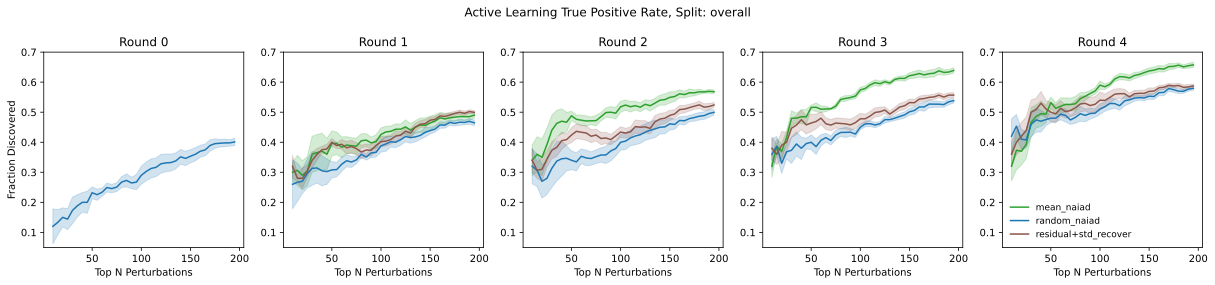

In [26]:
fig, axs = plt.subplots(1, n_round, figsize=((n_round*3)+2, 4)) # horizontal

for idx in range(n_round):
    if idx == 0:
        data_plot = data_stacked[(data_stacked['Round'] == idx) & (data_stacked['Method'] == methods[0]) & (data_stacked['Sampling'] == 'random')]
        sns.lineplot(data_plot, x='n_preds', y='tpr', errorbar='se', label='random', color=method_colors['random_naiad'], ax=axs[idx])
    
    if idx > 0:
        for method in methods:
            if method == 'overall':
                data_plot = copy.deepcopy(data_stacked)
                data_plot[[(data_stacked['Round'] == idx) & (data_stacked['Method'] == method) & (data_stacked['Sampling'] == 'active')]] \
                    = data_plot[[(data_stacked['Round'] == idx) & (data_stacked['Method'] == method) & (data_stacked['Sampling'] == 'active')]]
            data_plot = data_stacked[(data_stacked['Round'] == idx) & (data_stacked['Method'] == method) & (data_stacked['Sampling'] == 'active')]
            sns.lineplot(data_plot, x='n_preds', y='tpr', errorbar='se', label=method, color=method_colors[method], ax=axs[idx])

            # also plot random sampling for comparison
            
            data_plot = data_stacked[(data_stacked['Round'] == idx) & (data_stacked['Method'] == method) & (data_stacked['Sampling'] == 'random')]
            if 'naiad' in method:
                color = method_colors['random_naiad']
                label = 'random_naiad'
                sns.lineplot(data_plot, x='n_preds', y='tpr', errorbar='se', label=label, color=color, ax=axs[idx])

            elif 'recover' in method:
                color = method_colors['random_recover']
                label = 'random_recover'
                # sns.lineplot(data_plot, x='n_preds', y='tpr', errorbar='se', label=label, color=color, ax=axs[idx])

            

    ylims = axs[idx].get_ylim()
    if ylims[0] < min_ylim:
        min_ylim = ylims[0]
    if ylims[1] > max_ylim:
        max_ylim = ylims[1]

    axs[idx].set_title(f'Round {idx}')
    axs[idx].legend().remove()
    axs[idx].set_xlabel('Top N Perturbations')
    axs[idx].set_ylabel('')

# if orientation == 'horizontal':
axs[0].set_ylabel('Fraction Discovered')
# elif orientation == 'vertical':
#     axs[-1].set_xlabel('Top N Perturbations')
    
for ax in axs:
    # ax.set_ylim(min_ylim, max_ylim)
    ax.set_ylim(0.05, 0.7)
    if max_tpr is not None:
        ax.set_xticks([(i+1)*int(max_tpr/4) for i in range(4)])

axs[-1].legend(fontsize=9, frameon=False)

fig.suptitle(f'Active Learning True Positive Rate, Split: {split}')
fig.tight_layout()
# figs.append(fig)
plt.show()